# Import lib

In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q
!pip install accelerate -U
!pip install arabert
!pip install datasets
!nvidia-smi

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.2/7.2 MB 63.7 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 486.2/486.2 kB 47.4 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 118.9/118.9 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 66.4/66.4 kB 8.0 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 236.8/236.8 kB 25.9 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.8/7.8 MB 108.2 MB/s eta 0:00:00
     ‚îÅ‚

In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
from transformers import pipeline, set_seed
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric, Dataset
from tqdm import tqdm
import torch
from sklearn.utils import shuffle

from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def is_any_word_in_text(substrings, text):
    pattern = '|'.join([re.escape(substring) for substring in substrings])
    match = re.search(pattern, text)
    return bool(match)

In [ ]:
def filterDataframeByKeywords(df, column_name, search_keywords):
    df['Match'] = df[column_name].apply(lambda x: is_any_word_in_text(search_keywords, x))
    filtered_df = df[df['Match']]
    filtered_df = filtered_df.drop(["Match"], axis=1).reset_index(drop=True)
    return filtered_df

In [ ]:
def combineDataframes(dataframes):
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.drop_duplicates(inplace=True)
    return combined_df

In [ ]:
def extractHistoricalData(df, column_name):
    pattern = r'\b\d{4}\b'

    filtered_df = df[df[column_name].str.contains(pattern, regex=True)]
    return filtered_df

In [ ]:
def count_record_with_words(df, col_name, keywords_list):
    count = 0

    for index, row in df.iterrows():
        text = row[col_name]
        if any(keyword in text for keyword in search_keywords):
            count += 1

    print(f"Number of records containing any of the search keywords: {count}")

In [ ]:
keywords_list = ["ÿßŸÑŸÑŸá"
                 ,"ŸÖÿ≠ŸÖÿØ ÿπŸÑŸä"
                 , "ÿßŸÑŸÖŸÑŸÉ"
                 , "ŸÖÿØŸäŸÜÿ©"
                 , "ÿ±ŸàŸÖÿßŸÜ"
                 , "ÿ•ŸÖÿ®ÿ±ÿßÿ∑Ÿàÿ±"
                 , "ÿ¥ÿπÿ®"
                 , "ÿ®ÿ±Ÿäÿ∑ÿßŸÜŸäÿß"
                 , "ÿπÿ®ÿØ ÿßŸÑŸÜÿßÿµÿ±"
                 ,"ÿßŸÑŸÇÿßŸáÿ±ÿ©"
                 , "ÿ£ŸÉÿ™Ÿàÿ®ÿ±"
                 ,"ŸÅÿßÿ±ŸàŸÇ"
                 , "ÿßŸÑÿ≠Ÿäÿßÿ©"
                 , "ÿßŸÑÿ•ÿ≥ŸÉŸÜÿØÿ±Ÿäÿ©"
                 , "ÿßŸÑŸÇÿØŸäŸÖ"
                 , "ÿπÿµÿ±"
                 , "ŸÖÿ≥ŸÑŸÖ"
                 ,  "ÿ•ÿ≥ŸÑÿßŸÖ"
                 , "ÿßŸÑÿπÿßŸÑŸÖ"
                 , "ÿπŸÖÿ±"
                 , "ÿßŸÑŸÅÿ±ŸÜÿ≥Ÿäÿ©"
                 , "ÿπÿ±ÿßÿ®Ÿä"
                 ,  'ŸÖÿµÿ±'
                 , 'ÿ™ÿßÿ±ŸäÿÆ'
                 , 'ÿ≠ÿ∂ÿßÿ±ÿ©'
                 , 'ÿ≥Ÿäÿ≥Ÿä'
                 , 'ÿ®ÿßÿ¥ÿß'
                 , 'ÿ´Ÿàÿ±ÿ©'
                 , 'ÿπÿ±ÿ®Ÿä'
                 , 'ŸÖÿµÿ±Ÿä'
                 , 'ŸÖŸÖÿßŸÑŸäŸÉ'
                 , 'ÿØŸàŸÑÿ©'
                 , 'ÿØŸäŸÜ'
                 , 'ÿ≠ÿ±ÿ®'
                 , 'ÿ¨Ÿäÿ¥'
                 , 'ÿ≠ŸÉŸÖ'
                 , 'ÿ®ŸÑÿßÿØ'
                 , "ÿ±ÿ¶Ÿäÿ≥"
                , "ÿßŸÑÿπÿ±ÿßŸÇ"
                , "ŸÅÿ™ÿ≠"
                , "ÿßŸÑÿ≥ŸÑÿ∑ÿßŸÜ"
                , "ÿ®ÿßÿ®ŸÑ"
                , "ŸÇŸàÿßÿ™"
                , "ÿ±ŸàŸÖÿßŸÜ"
                , "ŸÅÿ±ŸÜÿ≥ÿß"]

# Working on xlsum dataset

In [ ]:
dataset_xlsum = load_dataset("csebuetnlp/xlsum", "arabic")

split_lengths = [len(dataset_xlsum[split])for split in dataset_xlsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_xlsum['train'].column_names}")
print("\nText:")

print(dataset_xlsum["test"][1]["text"])

print("\nSummary:")

print(dataset_xlsum["test"][1]["summary"])

In [ ]:
dataset_xlsum

In [ ]:
from datasets import concatenate_datasets


merged_xlsum_dataset = concatenate_datasets([dataset_xlsum["train"], dataset_xlsum["validation"], dataset_xlsum["test"]])

df_xlsum_merged = merged_xlsum_dataset.to_pandas()

print(df_xlsum_merged.shape)
print(df_xlsum_merged.columns)

In [ ]:
df_xlsum_merged.head()

In [ ]:
df_xlsum_merged = df_xlsum_merged.drop(["title", "url", "id"], axis=1)
df_xlsum_filtered = filterDataframeByKeywords(df_xlsum_merged, "summary", keywords_list)
df_xlsum_filtered['summary'], df_xlsum_filtered["text"] = df_xlsum_filtered["text"], df_xlsum_filtered['summary']
df_xlsum_filtered.rename(columns={'summary': 'text', "text": "summary"}, inplace=True)
df_xlsum_merged.head()

In [ ]:
print(df_xlsum_filtered.shape)
for i in range(5):
    print(f"summary {i}: ", df_xlsum_filtered.loc[i, "summary"])

# Working on labeld_validation dataset

In [ ]:
val_dataset = pd.read_json('/content/labeled_validation_dataset.jsonl', lines=True).drop(["example_id"], axis=1)
val_dataset.head()

In [ ]:
val_dataset.rename(columns={'paragraph': 'text'}, inplace=True)
val_dataset

# Concatenate the xlsum dataset and the validation dataset

In [ ]:
# Concatenate the data frames vertically (along rows)
concatenated_df = pd.concat([df_xlsum_filtered, val_dataset])

# Reset the index of the concatenated data frame
concatenated_df = concatenated_df.reset_index(drop=True)
concatenated_df.tail()

In [ ]:
concatenated_df.shape

In [ ]:
for i in range(5):
    print(f"summary {i}: ", concatenated_df.loc[i, "summary"])

In [ ]:
# concatenated_df.to_csv('xlsum_val_concatenated.csv', index=False)

# preprocess the data

In [ ]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import ISRIStemmer
from pyarabic.araby import strip_tashkeel

nltk.download('stopwords')
nltk.download('punkt')

# Initialize Arabic stopword list
stopwords_list = stopwords.words('arabic')

global count
count = 0

# Initialize Arabic stemmer
stemmer = ISRIStemmer()

def preprocess_arabic_text(text):
    # Text Cleaning
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags

    # Tokenization
    tokens = word_tokenize(text)

    # Stopword Removal
    tokens = [token for token in tokens if token not in stopwords_list]

    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]

    # Remove diacritics
    tokens = [strip_tashkeel(token) for token in tokens]

    # Join the tokens back into a preprocessed text
    preprocessed_text = ' '.join(tokens)
    global count
    count += 1
    print(count)
    return preprocessed_text

def preprocess_arabic_summary(summary):
    # Text Cleaning
    summary = re.sub(r'<.*?>', '', summary)  # Remove HTML tags

    # Tokenization
    tokens = word_tokenize(summary)

    # Stopword Removal
    tokens = [token for token in tokens if token not in stopwords_list]

    # Remove diacritics
    tokens = [strip_tashkeel(token) for token in tokens]

    # Join the tokens back into a preprocessed summary
    preprocessed_summary = ' '.join(tokens)
    global count
    count += 1
    print(count)
    return preprocessed_summary


In [ ]:
# Preprocess the 'text' column
concatenated_df['text'] = concatenated_df['text'].apply(preprocess_arabic_text)
count = 0
# Preprocess the 'summary' column
concatenated_df['summary'] = concatenated_df['summary'].apply(preprocess_arabic_summary)

In [ ]:
for i in range(5):
    print(f"summary {i}: ", concatenated_df.loc[i, "summary"])

In [ ]:
def empty_rows(df):
    empty_index = [index for index,text in enumerate(df.text.values) if str(text).strip() == '']
    print(f"Number of empty text rows: {len(empty_index)}")
    return df.iloc[empty_index].tail()
empty_rows(concatenated_df)

In [ ]:
def delete_links(input_text):
    pettern  = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))\)|[^\s`!()\[\]{};:'".,<>?¬´¬ª‚Äú‚Äù‚Äò‚Äô]))'''
    out_text = re.sub(pettern, ' ', input_text)
    return out_text

def delete_repeated_characters(input_text):
    pattern  = r'(.)\1{2,}'
    out_text = re.sub(pattern, r"\1\1", input_text)
    return out_text

def replace_letters(input_text):
    replace = {"ÿ£": "ÿß","ÿ©": "Ÿá","ÿ•": "ÿß","ÿ¢": "ÿß","": ""}
    replace = dict((re.escape(k), v) for k, v in replace.items())
    pattern = re.compile("|".join(replace.keys()))
    out_text = pattern.sub(lambda m: replace[re.escape(m.group(0))], input_text)
    return out_text

def clean_text(input_text):
    replace = r'[/(){}\[\]|@√¢√Ç,;\?\'\"\*‚Ä¶ÿü‚Äì‚Äôÿå!&\+-:ÿõ-]'
    out_text = re.sub(replace, " ", input_text)
    words = nltk.word_tokenize(out_text)
    words = [word for word in words if word.isalpha()]
    out_text = ' '.join(words)
    return out_text

def remove_vowelization(input_text):
    vowelization = re.compile(""" Ÿë|Ÿé|Ÿã|Ÿè|Ÿå|Ÿê|Ÿç|Ÿí|ŸÄ""", re.VERBOSE)
    out_text = re.sub(vowelization, '', input_text)
    return out_text

def delete_stopwords(input_text):
    stop_words = set(nltk.corpus.stopwords.words("arabic") + nltk.corpus.stopwords.words("english"))
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    wnl = nltk.WordNetLemmatizer()
    lemmatizedTokens =[wnl.lemmatize(t) for t in tokens]
    out_text = [w for w in lemmatizedTokens if not w in stop_words]
    out_text = ' '.join(out_text)
    return out_text

def stem_text(input_text):
    st = ISRIStemmer()
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    out_text = [st.stem(w) for w in tokens]
    out_text = ' '.join(out_text)

    return out_text

def text_prepare(input_text, ar_text):
    out_text = delete_links(input_text)
    out_text = delete_repeated_characters(out_text)
    out_text = clean_text(out_text)
#     out_text = delete_stopwords(out_text)
    if ar_text:
        out_text = replace_letters(out_text)
        out_text = remove_vowelization(out_text)
    else:
        out_text = out_text.lower()
    return out_text


def applyingPipeline(dataframe):
    dataframe["text"] = dataframe["text"].apply(text_prepare, args=(True,))
    dataframe["summary"] = dataframe["summary"].apply(text_prepare, args=(True,))
    return dataframe


#df1 = applyingPipeline(df, "text", keywords_list)

In [ ]:
# concatenated_df = applyingPipeline(concatenated_df)

In [ ]:
# concatenated_df.to_csv('xlsum_val_concatenated_preprocessed.csv', index=False)

# read preprocessed data from csv file

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/ICMTC Competition/

/content/drive/MyDrive/ICMTC Competition


In [5]:
concatenated_df = pd.read_csv("/content/drive/MyDrive/ICMTC Competition/dataset/xlsum_val_concatenated_preprocessed.csv")
concatenated_df.head()

text  \
0  ŸàŸÉÿßŸÜ ÿ±ÿ¶ÿ≥ ŸàŸÉÿ± ÿ§ŸÇÿ™ÿå ŸÉÿ≥ŸÜÿØÿ± ÿ™Ÿàÿ±ÿ™ÿ¥ŸäŸÜŸàŸÅÿå ÿßŸÖÿ± ÿ≥ÿ≠ÿ® ŸÇŸàÿ™...   
1  ÿ≠ŸÑŸÑ ÿπÿßŸÖ 2050 ÿ≠ÿßÿ¨ ŸÖÿµÿ± 21 ŸÑŸäÿ± ŸÖÿ™ÿ± ŸÉÿπÿ® ÿ≠ÿµÿ™ ÿ≠ŸÑŸä ÿ≠ÿ≥...   
2  ÿ∞ŸÉÿ± ŸàŸÉŸÑ ÿ®ÿßÿ° ÿ≠ŸÑÿ© ( ÿ¨Ÿä.ÿ•ŸÜ.ÿ•ÿ≥ ) ÿ¨ŸÖÿπ `` ÿ¨Ÿäÿ¥ ÿ≠ŸÖÿØ ''...   
3  ÿ≥ŸÑÿ≠ ÿ≠Ÿàÿ´ ÿßÿ® ŸàŸÇŸÑ ÿµÿØÿ± ÿ≥ŸÑÿ≠ ÿ≠Ÿàÿ´ Ÿáÿ¨ŸÖ ÿ¥ÿ∑ÿ° ÿ≠ÿ±ŸÉ ŸáŸÖŸä ÿ•ŸÅÿ¥...   
4  ÿµÿπÿ® ŸÇÿ±ÿ® ÿ≠ÿ≥ÿ® ÿ∂ÿ±ÿ± ÿ≥ÿ®ÿ® ÿßÿ≤ŸÖ ŸÑŸÄ '' ŸÑŸÉÿ≥ ŸÅÿ∫ŸÜ '' . ŸÅÿßŸÑ...   

                                             summary  
0      ÿ®ÿØÿ£ÿ™ ÿßŸÑŸÇŸàÿßÿ™ ÿßŸÑÿ£ŸàŸÉÿ±ÿßŸÜŸäÿ© ÿßŸÑÿßŸÜÿ≥ÿ≠ÿßÿ® ÿ¨ÿ≤Ÿäÿ±ÿ© ÿßŸÑŸÇÿ±ŸÖ .  
1  `` ÿ≥Ÿäÿ™ŸÖ ÿ™ÿ∫ŸäŸäÿ± ÿßŸÑÿπÿ®ÿßÿ±ÿ© ÿßŸÑÿ¥ŸáŸäÿ±ÿ© ŸÑŸÑŸÖÿ§ÿ±ÿÆ ÿßŸÑŸäŸàŸÜÿßŸÜŸä ...  
2  ŸÇÿßŸÑÿ™ ÿßŸÑÿ¥ÿ±ÿ∑ÿ© ÿßŸÑŸÇÿ∑ÿßÿπ ÿßŸÑŸáŸÜÿØŸä ÿ•ŸÇŸÑŸäŸÖ ŸÉÿ¥ŸÖŸäÿ± ÿßŸÜŸÅÿ¨ÿßÿ± ŸÇ...  
3  ÿ£ŸÉÿØ ŸÖÿµÿØÿ± `` ÿßŸÑÿ≠ÿ±ÿßŸÉ ÿßŸÑÿ™ŸáÿßŸÖŸä '' ŸÑÿ£ÿ®ŸÜÿßÿ° ŸÖÿ≠ÿßŸÅÿ∏ÿ© ÿßŸÑ...  
4  ÿ™ŸÖÿ± `` ŸÅŸàŸÑŸÉÿ≥ ŸÅÿßÿ∫ŸÜ '' ÿ®ÿ£ÿ≤ŸÖÿ© ÿπŸÖŸäŸÇÿ©ÿå ŸàŸáŸä ÿ¥ÿ±ŸÉÿ© ŸÉÿ®ÿ±...

In [ ]:
def get_sliced(df, percentage = 0.8, frac = 1, random_state = 123):
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=frac, random_state=random_state)

    # Calculate the number of rows for the slice
    slice_size = int(len(shuffled_df) * percentage)

    # Slice the DataFrame
    sliced_df = shuffled_df[:slice_size]
    return sliced_df.reset_index(drop=True)

In [ ]:
sliced_df = get_sliced(concatenated_df, 0.04)

In [ ]:
sliced_df.head()

text  \
0  ŸÇÿ∑ÿπ ÿ≠ÿ∑ŸÖ ŸÜŸÇŸÑ ÿ®ÿπŸÜ ŸÅÿ¶ŸÇ ÿßÿ±ÿ≥ ŸÖŸáÿØ ŸÜŸÇŸÑ ÿπŸÖŸÑ ÿ®ÿ≠ÿ´ ÿπÿ≥ŸÉÿ± ÿØ...   
1  ŸÉÿßŸÖŸäÿ± ŸäÿπŸÑ ÿßÿ≥ÿ™ŸÇÿßŸÑÿ™Ÿá ÿßŸÜ ÿÆÿßÿ± ŸÜÿÆÿ® ÿÆÿ±ÿ¨ ÿ™ÿ≠ÿØ Ÿàÿ±ÿ® ÿ£ÿÆÿ™ÿß...   
2  Ÿäÿ≤ÿØ ÿπÿ±ÿ∂ Ÿáÿ¨ÿ± ŸÜÿ∑ŸÇ ÿπÿ±ŸÇ . ÿ£ÿ∂ŸÅ ÿ≥ŸäÿØ `` ÿ≤ŸÑŸÜ ÿ±ÿ™ÿØ ŸÑÿ®ÿ≥ ÿµ...   
3  ÿßŸÇŸÖ ÿ∫ŸäŸÑŸÖ ŸÉÿ≥ŸÉ 20 ÿπŸÖÿß ŸàŸÉÿßŸÜ ÿ∫ŸäŸÑŸÖ ÿßŸáŸÖ ŸÉÿ™ÿ® ÿ¥ÿπÿ±ÿßÿ° ŸÑÿ∫...   
4  ÿ±ŸÉÿ≤ ŸÇÿ∂ÿ© ÿÆÿØŸÖ ŸÜŸÇŸÑ ŸÇÿ¶ŸÖ ÿ∑ÿ®ŸÇ UberPop ÿå ÿ±ÿ®ÿ∑ ÿÆÿØŸÖ Ÿàÿ®ŸäŸÜ...   

                                             summary  
0  ŸàÿµŸÑÿ™ ŸÇÿ∑ÿπÿ© ÿ≠ÿ∑ÿßŸÖ ÿ∑ÿßÿ¶ÿ±ÿ©ÿå Ÿäÿπÿ™ŸÇÿØ ÿßŸÑÿÆÿ®ÿ±ÿßÿ° ÿ£ŸÜŸáÿß ÿ±ÿ®ŸÖÿß ...  
1  ŸÑŸÑŸÖÿ±ÿ© ÿßŸÑÿ£ŸàŸÑŸâ ÿ™ÿßÿ±ŸäÿÆ ÿßŸÑÿßÿ™ÿ≠ÿßÿØ ÿßŸÑÿ£Ÿàÿ±Ÿàÿ®Ÿä ÿ™ÿµŸàÿ™ ÿßÿ≠ÿØŸâ ...  
2  ŸÇÿßŸÑÿ™ ÿ≥ŸäÿØÿ© ÿπÿ±ÿßŸÇŸäÿ© ÿßŸÑÿ∑ÿßÿ¶ŸÅÿ© ÿßŸÑÿ£Ÿäÿ≤ŸäÿØŸäÿ© ŸÖÿ≠ÿ™ÿ¨ÿ≤ÿ© ÿ™ŸÜÿ∏Ÿä...  
3  ÿ™ŸàŸÅŸä ÿßŸÑÿ¥ÿßÿπÿ± ÿßŸÑÿßÿ±ÿ¨ŸÜÿ™ŸäŸÜŸä ÿßŸÑŸÉÿ®Ÿäÿ± ÿÆŸàÿßŸÜ ÿ∫ŸäŸÑŸÖÿßŸÜ ÿπŸÖÿ± ...  
4  ŸÇÿ∂ÿ™ ŸÖÿ≠ŸÉŸÖÿ© ŸÅÿ±ŸÜÿ≥Ÿäÿ© ÿ®ÿ™ÿ∫ÿ±ŸäŸÖ ÿ¥ÿ±ŸÉÿ© `` ÿ£Ÿàÿ®ÿ± '' ŸÑÿÆÿØŸÖÿßÿ™...

In [ ]:
sliced_df.shape

(1166, 2)

# Pretrained Model

In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from arabert.preprocess import ArabertPreprocessor

#"abdalrahmanshahrour/arabartsummarization"
model_name="ahmeddbahaa/arabert2arabert-finetuned-ar-wikilingua"
preprocessor = ArabertPreprocessor(model_name="")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
pipeline = pipeline("text2text-generation",model=model,tokenizer=tokenizer)

# text = """Ÿàÿ™ÿ≠ÿ™ ÿπŸÜŸàÿßŸÜ ŸÖŸÜ ÿßŸÑŸÉÿßÿ±ÿ´ÿ© ÿ•ŸÑŸâ ÿßŸÑÿ™ÿ≠ÿØŸâ Ÿäÿ®ÿØÿ£ ÿßŸÑŸÉÿßÿ™ÿ® ÿπÿ±ÿ∂ ÿßŸÑŸÉÿ™ÿßÿ® ÿßŸÑÿ±ÿßÿ®ÿπ ÿå ÿ≠Ÿäÿ´ ŸäŸàÿ∂ÿ≠ ŸÉŸäŸÅ ŸÉÿßŸÜÿ™ ÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑ ŸÅÿ±ÿ≠ÿ© ÿ®ŸÜÿµÿ±Ÿáÿß ÿπÿßŸÖ 67 Ÿàÿ£ŸÜŸáÿß ÿßÿ±ÿ™ÿßÿ≠ÿ™ ŸÑÿßÿπÿ™ŸÇÿßÿØŸáÿß ÿ®ÿ£ŸÜ ŸáŸÜÿßŸÉ ŸàŸÇÿ™ÿß ÿ∑ŸàŸäŸÑÿß Ÿàÿ∑ŸàŸäŸÑÿß ÿ¨ÿØÿß ŸÇÿ®ŸÑ ÿ£ŸÜ ŸäŸÅŸäŸÇ ÿßŸÑÿπÿ±ÿ® ŸÖŸÜ ÿµÿØŸÖÿ© 67ÿå ŸàŸÉŸäŸÅ ÿ£ŸÜ ÿßŸÑŸÇŸàÿßÿ™ ÿßŸÑÿ¨ŸàŸäÿ© ŸÑŸÑÿ¨ŸÖŸáŸàÿ±Ÿäÿ© ÿßŸÑÿπÿ±ÿ®Ÿäÿ© ÿßŸÑŸÖÿ™ÿ≠ÿØÿ© ŸÇÿØ ŸÅÿßÿ¨ÿ£ÿ™Ÿáÿß ÿ®ÿπÿØ ÿ¥Ÿáÿ± Ÿàÿßÿ≠ÿØ ŸÖŸÜ ŸÜŸáÿßŸäÿ© ÿ≠ÿ±ÿ® 67 ÿ®Ÿáÿ¨ŸàŸÖ ÿ¨ŸàŸâ ÿπŸÜŸäŸÅ ÿπŸÑŸâ ŸÖŸàÿßŸÇÿπŸáÿß ŸÅŸâ ÿ≥ŸäŸÜÿßÿ° ŸàŸÉÿßŸÜ Ÿáÿ∞ÿß ÿ•ÿπŸÑÿßŸÜÿß ÿπŸÜ ÿ®ÿØÿßŸäÿ© ÿ≠ÿ±ÿ® ŸÖŸÜ ŸÜŸàÿπ ÿ¨ÿØŸäÿØ ŸáŸâ ÿ≠ÿ±ÿ® ÿßŸÑÿßÿ≥ÿ™ŸÜÿ≤ÿßŸÅ ÿßŸÑÿ™Ÿâ ÿßÿ≥ÿ™ŸÖÿ±ÿ™ ÿ≠ÿ™Ÿâ ÿ™ŸÖ ŸàŸÇŸÅ ÿ•ÿ∑ŸÑÿßŸÇ ÿßŸÑŸÜÿßÿ± ÿ®ŸäŸÜ ÿßŸÑÿ∑ÿ±ŸÅŸäŸÜ ŸÅŸâ 8 ÿ£ÿ∫ÿ≥ÿ∑ÿ≥ 1970ÿå ÿ´ŸÖ ŸàŸÅÿßÿ© ÿπÿ®ÿØÿßŸÑŸÜÿßÿµÿ± Ÿàÿ™ŸàŸÑŸâ ÿ£ŸÜŸàÿ± ÿßŸÑÿ≥ÿßÿØÿßÿ™ ÿ≠ŸÉŸÖ ŸÖÿµÿ± Ÿàÿßÿ≥ÿ™ÿπÿØÿßÿØŸá ŸÑŸÑÿ≠ÿ±ÿ® . ŸàŸäÿ™ÿπÿ±ÿ∂ ÿßŸÑŸÉÿßÿ™ÿ® ÿ£Ÿäÿ∂ÿß Ÿàÿ®ÿµŸàÿ±ÿ© ÿ≥ÿ±Ÿäÿπÿ© ŸÑŸÅŸÑÿ≥ÿ∑ŸäŸÜ ŸàÿßŸÑÿ£ÿ±ÿØŸÜ Ÿàÿ≥Ÿàÿ±Ÿäÿß ŸÇÿ®ŸÑ ÿ£ŸÜ ŸäŸÜÿ™ŸÇŸÑ ÿ•ŸÑŸâ ÿßŸÑŸÉÿ™ÿßÿ® ÿßŸÑÿÆÿßŸÖÿ≥ ÿπŸÜ ÿ≠ÿ±ÿ® ÿ£ŸÉÿ™Ÿàÿ®ÿ± ÿå ÿ≠Ÿäÿ´ Ÿäÿπÿ±ÿ∂ ÿßŸÑÿÆÿ∑ÿ∑ ŸàÿßŸÑÿßÿ≥ÿ™ÿπÿØÿßÿØÿßÿ™ ÿßŸÑŸÖÿµÿ±Ÿäÿ© ÿ´ŸÖ ÿßŸÑÿßÿ≥ÿ™ÿπÿØÿßÿØÿßÿ™ ÿßŸÑÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑŸäÿ© ÿ´ŸÖ Ÿäÿ®ÿØÿ£ ÿ®ÿπÿ±ÿ∂ ŸàŸÇÿßÿ¶ÿπ ÿßŸÑÿ≠ÿ±ÿ® ÿ®ÿØÿßŸäÿ© ŸÖŸÜ ÿßŸÑÿ∂ÿ±ÿ®ÿ© ÿßŸÑÿ¨ŸàŸäÿ© ŸàÿßŸÜŸáŸäÿßÿ± ÿÆÿ∑ ÿ®ÿßÿ±ŸÑŸäŸÅ ŸàÿßÿÆÿ™ÿ±ÿßŸÇŸá ÿå ŸàŸäÿ™ŸàŸÇŸÅ ÿßŸÑŸÉÿßÿ™ÿ® ÿπŸÜÿØ ŸäŸàŸÖ 8 ÿ£ŸÉÿ™Ÿàÿ®ÿ± ÿå ŸàŸäŸÇŸàŸÑ : ÿ•ŸÜ Ÿáÿ∞ÿß ÿßŸÑŸäŸàŸÖ ŸÉÿßŸÜ ÿßÿ≥Ÿàÿ£ Ÿáÿ≤ŸäŸÖÿ© ŸÅŸâ ÿ™ÿßÿ±ŸäÿÆ ÿßŸÑÿ¨Ÿäÿ¥ ÿßŸÑÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑŸâ ÿ´ŸÖ ŸäŸÜÿ™ŸÇŸÑ ÿ®ŸÜÿß ÿßŸÑŸÖÿ§ŸÑŸÅ ÿ•ŸÑŸâ ÿßŸÑÿ¨ÿ®Ÿáÿ© ÿßŸÑÿ≥Ÿàÿ±Ÿäÿ© ÿ´ŸÖ ŸäÿπŸàÿØ ÿ´ÿßŸÜŸäÿ© ÿ•ŸÑŸâ ŸäŸàŸÖŸäÿßÿ™ ÿßŸÑÿ≠ÿ±ÿ® ÿ≠ÿ™Ÿâ 7 9 ÿ£ŸÉÿ™Ÿàÿ®ÿ± ÿ•ŸÑŸâ 9 13 ÿ£ŸÉÿ™Ÿàÿ®ÿ± ÿ´ŸÖ 14 ÿ£ŸÉÿ™Ÿàÿ®ÿ± ÿå ÿ´ŸÖ Ÿäÿπÿ±ÿ∂ ŸÑŸÑÿ´ÿ∫ÿ±ÿ© ÿ£Ÿà ŸÖÿß ÿπÿ±ŸÅ ÿ®ÿπŸÖŸÑŸäÿ© ÿßŸÑŸÖÿ≤ÿ±ÿπÿ© ÿßŸÑÿµŸäŸÜŸäÿ© ŸäŸàŸÖ 16 Ÿà 15 ÿ£ŸÉÿ™Ÿàÿ®ÿ± ŸàÿßŸÑŸÖÿ≥ÿßÿπÿØÿßÿ™ ÿßŸÑÿ£ŸÖÿ±ŸäŸÉŸäÿ© ÿßŸÑÿ∂ÿÆŸÖÿ© ŸÑÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑ ÿå ÿ´ŸÖ ÿ®ÿØÿßŸäÿ© ÿßŸÑÿ∂ÿ∫Ÿàÿ∑ ÿßŸÑÿ≥Ÿäÿßÿ≥Ÿäÿ© ÿπŸÑŸâ ÿßŸÑÿ±ÿ¶Ÿäÿ≥ ÿ£ŸÜŸàÿ± ÿßŸÑÿ≥ÿßÿØÿßÿ™ ŸÖŸÜ 17 19 ÿ£ŸÉÿ™Ÿàÿ®ÿ± ÿ´ŸÖ ŸäŸÜÿ™ŸÇŸÑ ÿßŸÑŸÉÿßÿ™ÿ® ŸÑŸÑÿ£ÿ≠ÿØÿßÿ´ ÿßŸÑÿ™Ÿâ ÿ¨ÿ±ÿ™ ŸÖŸÜ 17 20 ÿ£ŸÉÿ™Ÿàÿ®ÿ± Ÿàÿ•ÿπŸÅÿßÿ° ÿßŸÑŸÅÿ±ŸäŸÇ ÿßŸÑÿ¥ÿßÿ∞ŸÑŸâ ŸÖŸÜ ŸÖŸÜÿµÿ®Ÿá ŸÉÿ±ÿ¶Ÿäÿ≥ ŸÑÿ£ÿ±ŸÉÿßŸÜ ÿßŸÑŸÇŸàÿßÿ™ ÿßŸÑŸÖÿ≥ŸÑÿ≠ÿ© ÿßŸÑŸÖÿµÿ±Ÿäÿ© ÿå Ÿàÿ™ŸàŸÑŸâ ÿßŸÑŸÅÿ±ŸäŸÇ ÿßŸÑÿ¨ŸÖÿ≥Ÿâ ÿ®ÿØŸÑÿß ŸÖŸÜŸá ÿ´ŸÖ ÿßŸÑÿßÿ™ÿ¨ÿßŸá ÿ•ŸÑŸâ ÿßŸÑŸÖŸàÿßŸÅŸÇÿ© ÿπŸÑŸâ ÿ∑ŸÑÿ® ŸàŸÇŸÅ ÿ•ÿ∑ŸÑÿßŸÇ ÿßŸÑŸÜÿßÿ± ŸàÿßŸÑÿÆŸÑÿßŸÅ ŸÖÿπ ÿ≥Ÿàÿ±Ÿäÿß ÿ®ÿ¥ÿ£ŸÜ Ÿáÿ∞ÿß ÿßŸÑÿ£ŸÖÿ± ÿå ÿ´ŸÖ ÿ®ÿØÿßŸäÿ© ÿßŸÑŸáÿ¨ŸàŸÖ ÿßŸÑÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑŸâ ŸÖŸÜ 19 ÿ•ŸÑŸâ 22 ÿ£ŸÉÿ™Ÿàÿ®ÿ± ÿπŸÑŸâ ÿßŸÑÿ∂ŸÅÿ© ÿßŸÑÿ∫ÿ±ÿ®Ÿäÿ© ŸÑŸÇŸÜÿßÿ© ÿßŸÑÿ≥ŸàŸäÿ≥ ŸàÿßŸÑÿπŸÖŸÑŸäÿßÿ™ ÿßŸÑŸÜŸáÿßÿ¶Ÿäÿ© ŸÅŸâ ÿ≥Ÿàÿ±Ÿäÿß 14 23 ÿ£ŸÉÿ™Ÿàÿ®ÿ± ÿå ŸàŸÉŸäŸÅ ÿ£ŸÜ ÿßŸÑŸÖŸÑŸÉ ÿ≠ÿ≥ŸäŸÜ ŸÇÿ±ÿ± ÿØÿÆŸàŸÑ ÿßŸÑÿ≠ÿ±ÿ® ÿ∂ÿØ ÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑ ŸäŸàŸÖ 9 ÿ£ŸÉÿ™Ÿàÿ®ÿ± ÿå ÿ´ŸÖ Ÿäÿπÿ±ÿ∂ ÿßŸÑŸÉÿßÿ™ÿ® ÿßŸÑŸÖÿπÿ±ŸÉÿ© ÿßŸÑÿÆÿßÿµÿ© ÿ®ÿßŸÑÿßÿ≥ÿ™ŸäŸÑÿßÿ° ÿπŸÑŸâ ŸÖÿØŸäŸÜÿ© ÿßŸÑÿ≥ŸàŸäÿ≥ ŸÖŸÜ 23 ÿ£ŸÉÿ™Ÿàÿ®ÿ± ÿ•ŸÑŸâ 25 ÿ£ŸÉÿ™Ÿàÿ®ÿ± ÿ´ŸÖ ÿ™ÿ∑Ÿàÿ±ÿßÿ™ Ÿáÿ∞Ÿá ÿßŸÑŸÖÿπÿ±ŸÉÿ© ÿå ŸàŸÉŸäŸÅ ÿ£ŸÜŸá ŸÖÿπ ÿ≠ŸÑŸàŸÑ ŸäŸàŸÖ ÿßŸÑÿ≥ÿßÿ®ÿπ ŸàÿßŸÑÿπÿ¥ÿ±ŸäŸÜ ŸÖŸÜ ÿ£ŸÉÿ™Ÿàÿ®ÿ± ŸÉÿßŸÜ ÿßŸÑÿ•ÿ≥ÿ±ÿßÿ¶ŸäŸÑŸäŸàŸÜ ŸÇÿØ ÿ£ÿ≥ÿ±Ÿàÿß ŸÜÿ≠Ÿà ÿ´ŸÖÿßŸÜŸäÿ© ÿ¢ŸÑÿßŸÅ ŸÅÿ±ÿØ ŸÖŸÜ ÿßŸÑŸÇŸàÿßÿ™ ÿßŸÑŸÖÿµÿ±Ÿäÿ© ÿå ÿ£ÿ∫ŸÑÿ®ŸáŸÖ ŸÖŸÜ Ÿàÿ≠ÿØÿßÿ™ ÿßŸÑÿ•ŸÖÿØÿßÿØ ŸàÿßŸÑÿ™ŸÖŸàŸäŸÜ"""
# text = preprocessor.preprocess(text)

# result = pipeline(text,
#             pad_token_id=tokenizer.eos_token_id,
#             num_beams=3,
#             repetition_penalty=3.0,
#             max_length=200,
#             length_penalty=1.0,
#             no_repeat_ngram_size = 3)[0]['generated_text']
# result

# Prepare data for finetuning

In [7]:
def make_dataset_from_dataframe(df, train_ratio= 0.8, val_ratio = 0.1, test_ratio = 0.1):
    # Shuffle the DataFrame
    df = shuffle(df, random_state=42)

    # Split the DataFrame into train, validation, and test sets
    train_size = int(train_ratio * len(df))
    val_size = int(val_ratio * len(df))
    test_size = len(df) - train_size - val_size


    train_df = df[:train_size]
    val_df = df[train_size : train_size + val_size]
    test_df = df[-test_size:]

    # Convert the train, validation, and test DataFrames to datasets.arrow_dataset.Dataset
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)

    return train_dataset, val_dataset, test_dataset

In [8]:
train_dataset, val_dataset, test_dataset = make_dataset_from_dataframe(concatenated_df)

In [9]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'summary', '__index_level_0__'],
    num_rows: 23322
})
Dataset({
    features: ['text', 'summary', '__index_level_0__'],
    num_rows: 2915
})
Dataset({
    features: ['text', 'summary', '__index_level_0__'],
    num_rows: 2916
})


In [9]:
train_dataset = train_dataset.remove_columns('__index_level_0__')
val_dataset = val_dataset.remove_columns('__index_level_0__')
test_dataset = test_dataset.remove_columns('__index_level_0__')

In [11]:
print("\nText:")

print(train_dataset["text"][0])

print("\nSummary:")

print(train_dataset["summary"][0])


Text:
ŸÅÿ¥ŸÑ ŸäŸáŸà ÿ¥ŸÉŸÑ ÿ¶ŸÑŸÅ ÿ≠ŸÉŸÖ ÿÆŸÑŸÑ ŸáŸÑÿ© 28 ŸäŸàŸÖ ŸàŸÑŸâ ŸàŸÇŸÑ Ÿäÿ±ÿ≤ ÿßŸÖŸÖ ŸÑŸÅÿ≤ ÿßÿ≥ÿ™ŸÇÿ®ÿßŸÑŸá ŸäŸáŸà ŸÇÿ±Ÿá ŸÇÿØÿ≥ ÿ≥ÿ®ÿ™ `` ŸÖŸÜÿ≠ ÿ≥ÿ®ÿπ ÿßÿ∂ÿßŸÅŸäŸäŸÜÿå ŸàŸÅŸÇ ŸÇÿßŸÜŸàŸÜÿå ŸÑÿßÿ≥ÿ™ŸÉŸÖÿßŸÑ ŸáŸÖÿ© ÿ¥ŸÉŸÑ ÿ≠ŸÉŸÖ '' . ŸàÿµŸÑ ÿ≠ÿØÿ´ ÿ¥ÿ±ŸÉÿßÿ° ÿ≠ŸÖŸÑ ÿ¶ŸÑŸÅ ÿ≠ŸÉŸÖ ÿ∑ÿ±ŸÇ ÿ≥ÿØÿØ ŸÜÿÆÿ® 22 ŸäŸÜÿßŸäÿ±/ŸÉÿßŸÜ ÿ´ŸÜŸä ÿßÿ∂Ÿä . Ÿàÿ∞ÿß Ÿäÿ™ŸÖ ŸäŸáŸà ÿ¥ŸÉŸÑ ÿ≠ŸÉŸÖ ÿ≠ŸÑŸÑ 16 ŸÖÿßÿ±ÿ≥/ÿ¢ÿ∞ÿßÿ±ÿå ŸÖŸÉŸÜ ÿßŸÜ ÿ™ÿ™ŸÖ ÿØÿπÿ© ŸÜÿÆÿ® ÿ¨ÿØŸäÿØÿ©ÿå ŸäŸÑŸÇ ÿ∏ŸÑŸÑ ÿßŸÑÿ¥ ÿ≤Ÿäÿ± ŸÇÿ±ÿ± ÿ±ÿ¶ÿ≥ ÿßŸÖÿ± ÿ®ÿ±ÿß ÿßŸàÿ® ÿ±ÿßÿ¶ŸäŸÑ . ŸàŸÅŸä ÿ®ŸäŸÜ ŸÇÿ∂ÿ® ÿ¨ŸÖÿπ ÿ±ÿ¶ÿ≥ ÿßÿ≥ÿ±ÿßÿ¶ŸäŸÑŸäÿå ŸÑŸÖÿ≠ ŸäŸáŸà ÿßŸÜ ÿ¥ÿ±ŸÉ ÿ≠ŸÖŸÑ Ÿàÿ≠ÿØ ÿßŸÇŸÑ ÿ¶ŸÑŸÅ ÿ±ŸÅÿ∂ ÿ¨ŸÑÿ≥ ÿ®ŸÇÿ© ÿ¥ÿ±ŸÉÿßÿ° ÿ≠ŸÖŸÑ . ŸÖŸàÿßÿ∂Ÿäÿπ ÿ™ŸáŸÖ ŸÜŸáŸä ÿ∑ŸÑÿ® Ÿàÿ¨Ÿá ŸäŸáŸà ÿ∑ŸÑÿ® ÿ≠ÿ≤ÿ® ÿ≠ŸÑÿß ÿ±ŸÉÿ≤ ÿ´ŸÑÿ´ ÿ±ÿ®ÿπ ŸàŸáŸÖ ÿ≠ÿ≤ÿ® `` Ÿàÿ¨ÿØ ŸÇÿ®ŸÑ '' ÿ≠ÿ≤ÿ® `` ÿ®Ÿäÿ™ ŸäŸáÿØ '' ÿÆŸÅÿ∂ ÿπŸÅÿ° ÿ¨ŸÜÿØ ÿ¨ÿ®ÿ± ÿÆŸÅÿ∂ ŸÖŸäÿ≤ ÿßŸÇÿ™ÿµÿßÿØŸäÿ© ŸÖŸÜÿ≠ ÿØŸàŸÑ ŸäŸáÿØ ÿ™ÿ¥ÿØÿØ . ŸàŸÇŸÑ ŸÉÿ®ÿ± ŸÅÿßÿ∂ ŸÅÿ±ŸÇ ŸäŸáŸà ÿ≠ÿØÿ´ ÿ¶ŸÑŸÅ ŸäŸàŸÖ ÿ¨ŸÖÿπ ÿ®Ÿäÿ™ ŸäŸáÿ

# visualization

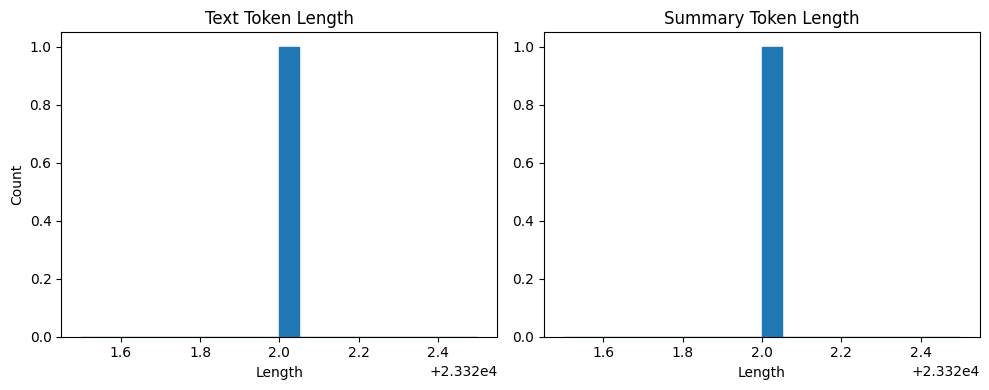

In [12]:
text_token_len = len([tokenizer.encode(s) for s in train_dataset["text"]])

summary_token_len = len([tokenizer.encode(s) for s in train_dataset["summary"]])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(text_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Text Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

# convert_examples_to_features

In [10]:
def convert_examples_to_features(example_batch):
    # max_length 1024 or 512
    input_encodings = tokenizer(example_batch['text'] , max_length = 512, truncation = True, padding="max_length", return_tensors="pt" )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

In [11]:
train_dataset_pt = train_dataset.map(convert_examples_to_features, batched = True)
test_dataset_pt = test_dataset.map(convert_examples_to_features, batched = True)
val_dataset_pt = val_dataset.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/23322 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3619: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2916 [00:00<?, ? examples/s]

Map:   0%|          | 0/2915 [00:00<?, ? examples/s]

In [12]:
print(train_dataset_pt)
print("\nText:")
print(train_dataset_pt["text"][0])

print("\nSummary:")
print(train_dataset_pt["summary"][0])

print("\nInput_ids:")
print(train_dataset_pt["input_ids"][0])

print("\nAttention_mask:")
print(train_dataset_pt["attention_mask"][0])

print("\nLabels:")
print(train_dataset_pt["labels"][0])

Dataset({
    features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 23322
})

Text:
ŸÅÿ¥ŸÑ ŸäŸáŸà ÿ¥ŸÉŸÑ ÿ¶ŸÑŸÅ ÿ≠ŸÉŸÖ ÿÆŸÑŸÑ ŸáŸÑÿ© 28 ŸäŸàŸÖ ŸàŸÑŸâ ŸàŸÇŸÑ Ÿäÿ±ÿ≤ ÿßŸÖŸÖ ŸÑŸÅÿ≤ ÿßÿ≥ÿ™ŸÇÿ®ÿßŸÑŸá ŸäŸáŸà ŸÇÿ±Ÿá ŸÇÿØÿ≥ ÿ≥ÿ®ÿ™ `` ŸÖŸÜÿ≠ ÿ≥ÿ®ÿπ ÿßÿ∂ÿßŸÅŸäŸäŸÜÿå ŸàŸÅŸÇ ŸÇÿßŸÜŸàŸÜÿå ŸÑÿßÿ≥ÿ™ŸÉŸÖÿßŸÑ ŸáŸÖÿ© ÿ¥ŸÉŸÑ ÿ≠ŸÉŸÖ '' . ŸàÿµŸÑ ÿ≠ÿØÿ´ ÿ¥ÿ±ŸÉÿßÿ° ÿ≠ŸÖŸÑ ÿ¶ŸÑŸÅ ÿ≠ŸÉŸÖ ÿ∑ÿ±ŸÇ ÿ≥ÿØÿØ ŸÜÿÆÿ® 22 ŸäŸÜÿßŸäÿ±/ŸÉÿßŸÜ ÿ´ŸÜŸä ÿßÿ∂Ÿä . Ÿàÿ∞ÿß Ÿäÿ™ŸÖ ŸäŸáŸà ÿ¥ŸÉŸÑ ÿ≠ŸÉŸÖ ÿ≠ŸÑŸÑ 16 ŸÖÿßÿ±ÿ≥/ÿ¢ÿ∞ÿßÿ±ÿå ŸÖŸÉŸÜ ÿßŸÜ ÿ™ÿ™ŸÖ ÿØÿπÿ© ŸÜÿÆÿ® ÿ¨ÿØŸäÿØÿ©ÿå ŸäŸÑŸÇ ÿ∏ŸÑŸÑ ÿßŸÑÿ¥ ÿ≤Ÿäÿ± ŸÇÿ±ÿ± ÿ±ÿ¶ÿ≥ ÿßŸÖÿ± ÿ®ÿ±ÿß ÿßŸàÿ® ÿ±ÿßÿ¶ŸäŸÑ . ŸàŸÅŸä ÿ®ŸäŸÜ ŸÇÿ∂ÿ® ÿ¨ŸÖÿπ ÿ±ÿ¶ÿ≥ ÿßÿ≥ÿ±ÿßÿ¶ŸäŸÑŸäÿå ŸÑŸÖÿ≠ ŸäŸáŸà ÿßŸÜ ÿ¥ÿ±ŸÉ ÿ≠ŸÖŸÑ Ÿàÿ≠ÿØ ÿßŸÇŸÑ ÿ¶ŸÑŸÅ ÿ±ŸÅÿ∂ ÿ¨ŸÑÿ≥ ÿ®ŸÇÿ© ÿ¥ÿ±ŸÉÿßÿ° ÿ≠ŸÖŸÑ . ŸÖŸàÿßÿ∂Ÿäÿπ ÿ™ŸáŸÖ ŸÜŸáŸä ÿ∑ŸÑÿ® Ÿàÿ¨Ÿá ŸäŸáŸà ÿ∑ŸÑÿ® ÿ≠ÿ≤ÿ® ÿ≠ŸÑÿß ÿ±ŸÉÿ≤ ÿ´ŸÑÿ´ ÿ±ÿ®ÿπ ŸàŸáŸÖ ÿ≠ÿ≤ÿ® `` Ÿàÿ¨ÿØ ŸÇÿ®ŸÑ '' ÿ≠ÿ≤ÿ® `` ÿ®Ÿäÿ™ ŸäŸáÿØ '' ÿÆŸÅÿ∂ ÿπŸÅÿ° ÿ¨ŸÜÿØ ÿ¨ÿ®ÿ± ÿÆŸÅÿ∂ ŸÖŸäÿ≤ ÿßŸÇÿ™ÿµÿßÿØŸäÿ

# Train model

In [13]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
%cd /content/drive/MyDrive/ICMTC Competition/model

/content/drive/MyDrive/ICMTC Competition/model


In [16]:
from transformers import TrainingArguments, Trainer
trainer_args = TrainingArguments(
    output_dir='arabertWiki-xlsum', num_train_epochs=10, warmup_steps=500,
    per_device_train_batch_size=2, per_device_eval_batch_size=4,
    weight_decay=0.1, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True  # Add load_best_model_at_end
)

In [17]:
from transformers import EarlyStoppingCallback
# Define the early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=5)

trainer = Trainer(model=model, args=trainer_args,
                    tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                    train_dataset=train_dataset_pt,
                    eval_dataset=val_dataset_pt,
                    callbacks=[early_stopping_callback]  # Add the early stopping callback
)



In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:642: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to p

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-3435b262f1ae>", line 1, in <cell line: 1>
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1645, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2020, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2307, in _maybe_log_save_evaluate
    self.log(logs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2672, in log
    self.control = self.callback_handler.on_log(self.args, self.state, self.control, logs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer_callback.py"

In [18]:
#save model
model.save_pretrained("/content/drive/MyDrive/ICMTC competion/model/arabert-xlsum-model")

# Save tokenizer
tokenizer.save_pretrained("/content/drive/MyDrive/ICMTC competion/model/tokenizer")

('/content/drive/MyDrive/ICMTC competion/model/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/ICMTC competion/model/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/ICMTC competion/model/tokenizer/vocab.txt',
 '/content/drive/MyDrive/ICMTC competion/model/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/ICMTC competion/model/tokenizer/tokenizer.json')

# Evaluating the model

In [19]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [20]:


def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]



def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

rouge_metric = load_metric('rouge')

<ipython-input-21-67199026c897>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library ü§ó Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-67199026c897>", line 3, in <cell line: 3>
    rouge_metric = load_metric('rouge')
  File "/usr/local/lib/python3.10/dist-packages/datasets/utils/deprecation_utils.py", line 46, in wrapper
    return deprecated_function(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/datasets/load.py", line 1397, in load_metric
    metric_module = metric_module_factory(
  File "/usr/local/lib/python3.10/dist-packages/datasets/utils/deprecation_utils.py", line 46, in wrapper
    return deprecated_function(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/datasets/load.py", line 1328, in metric_module_factory
    raise e1 from None
  File "/usr/local/lib/python3.10/dist-packages/datasets/load.py", line 1320, in metric_module_factory
    ).get_module()
  Fil

In [ ]:
score = calculate_metric_on_test_ds(
    test_dataset_pt, rouge_metric, trainer.model, tokenizer, batch_size = 8, column_text = 'text', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['arabert'] )

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-e39e0537f5f9>", line 2, in <cell line: 1>
    test_dataset_pt, rouge_metric, trainer.model, tokenizer, batch_size = 8, column_text = 'text', column_summary= 'summary'
NameError: name 'rouge_metric' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(et

# all in one